#### Contest entry by Wouter Kimman 


Strategy: 
----------------------------------------------

--------------------------------------------------------------------------------------------
Trying some pre-processing with simple random forest..hopefully preprocessing as important as type of classifier

The problem has a smell of descision trees to me, since most predictions of the neighboring 
facies are very accurate. 

--------------------------------------------------------------------------------------------

In [38]:
from numpy.fft import rfft
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py


import pandas as pd
import timeit
from sqlalchemy.sql import text
from sklearn import tree
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import sherlock.filesystem as sfs
#import sherlock.database as sdb

from sklearn import preprocessing

from sklearn.cross_validation import train_test_split

First steps, reading in and exploring the data are the same as Brendon's steps:

In [1344]:
filename = 'training_data.csv'
training_data0 = pd.read_csv(filename)
training_data0.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


1) Prediction from training set using all wells
-------------------------------------------------------
Let's do a first shot with random forests. 
First we cheat and see how awesome we would do if the test data was not from an independent well

In [1350]:
correct_facies_labels = training_data0['Facies'].values

feature_vectors = training_data0.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


scale the data:

In [1351]:
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [1352]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,  correct_facies_labels, test_size=0.2, random_state=0)


In [1355]:
rf = RandomForestClassifier(max_depth = 15,n_estimators=200,max_features=None)
#rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_random_forest = rf.predict(X_test)

print "prediction from random forest:"
print metrics.accuracy_score(list(y_test), predicted_random_forest)

print "f1 score:"
print metrics.f1_score(list(y_test), predicted_random_forest,average = 'weighted')

prediction from random forest:
0.724884080371
f1 score:
0.725714762122


In [1356]:
training_data=training_data0.copy()


2) Prediction of Blind well
---------------------------------------------


In [1357]:
#remove 1 well
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

In [1358]:
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [1359]:
X_train, dum1, y_train, dum2 = train_test_split(scaled_features,  correct_facies_labels, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1360]:
# get the blind well
correct_facies_labels = blind['Facies'].values
feature_vectors = blind.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)


In [1361]:
predicted_random_forest = rf.predict(scaled_features)
print "All training data different from test well"
print "prediction from random forest:"
print metrics.accuracy_score(correct_facies_labels, predicted_random_forest)

print "f1 score:"
print metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'weighted')

All training data different from test well
prediction from random forest:
0.456570155902
f1 score:
0.443892955065


The prediction performs much much beter if the all data is included in the training,
compared to blind wells. Shouldn't be that much a surprise but doesn't this suggest some wells
are not representative of the others



In [1362]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

#conf = confusion_matrix(correct_facies_labels, predicted_gradboost)
conf = confusion_matrix(correct_facies_labels, predicted_random_forest)

display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    15    73     1                                        89
     CSiS     9    65    15                                        89
     FSiS     1    61    55                                       117
     SiSh                                   6           1           7
       MS                       6           8           5          19
       WS                 2     1     2    43          23          71
        D                                         7    10          17
       PS                                  14     3    20     3    40
       BS                                                           0


This is the benchmark to beat : 0.44 using rf, (slightly higher for gradient boost)

------------------------------------------




3) Data exploration
-----------------------------------------------------------------

Basic statistics by facies:

In [1668]:
temp_1=training_data.groupby('Formation').mean()
temp_2=training_data.groupby('Facies').mean()
#temp_3=training_data.groupby('Facies').count()
temp_2

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,,,,,,,,
1,2749.503861,64.497761,0.371312,3.506463,14.818996,2.913313,1.000000,0.452486
2,2837.130081,74.605205,0.548171,5.309705,15.189019,3.215267,1.008130,0.491150
3,2875.241463,79.915083,0.547504,3.797480,20.619698,3.132340,1.026016,0.560979
4,2867.282609,92.169957,0.776840,5.579728,11.152821,3.802152,1.972826,0.421908
5,2957.559908,60.612788,0.820655,3.735212,9.562668,3.995184,1.949309,0.590733
6,2892.073593,55.554532,0.884502,2.728424,7.442779,4.234136,1.995671,0.493753
7,2926.974490,64.614643,0.465649,5.034133,14.080418,3.671286,1.989796,0.600520
8,2891.041165,47.195886,0.747021,1.444823,9.585972,4.518653,1.975904,0.585058
9,3033.400621,44.877280,0.574677,0.198547,13.226944,5.295925,2.000000,0.451925


Basic statistics by well:

In [1364]:
temp_4=training_data.groupby('Well Name')
#temp_4.describe()
#temp_5=training_data.groupby('Well Name').count()
#temp_5=training_data.groupby('Well Name').max()
temp_5=training_data.groupby('Well Name').mean()
temp_5

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Well Name,,,,,,,,,
CHURCHMAN BIBLE,5.655941,3019.482673,63.683453,0.758757,1.560000,14.011116,3.789926,1.722772,0.544317
CROSS H CATTLE,3.127745,2702.360279,72.699285,0.568829,2.466667,15.574850,3.325852,1.297405,0.506182
LUKE G U,4.353579,2725.708243,64.777223,0.639690,4.218438,12.953905,3.660705,1.466377,0.514095
NEWBY,4.801296,2941.500000,60.733045,0.674812,3.477970,11.625378,3.771706,1.615551,0.528138
NOLAN,4.643373,2957.000000,68.693940,0.592400,3.134070,12.197361,3.857947,1.527711,0.549007
Recruit F9,9.000000,3038.367647,44.712853,0.567853,1.436515,13.183368,5.460735,2.000000,0.448279
SHRIMPLIN,4.384289,2910.501062,69.408896,0.659679,7.708493,12.173705,4.219958,1.488323,0.514482


4 ) Select a feature from 1 well and play with this
--------------------------------------------------------


In [1373]:
xx0 = list(training_data0.Facies)
#xx1 = list(training_data0.DeltaPHI)
xx1 = list(training_data0.GR)


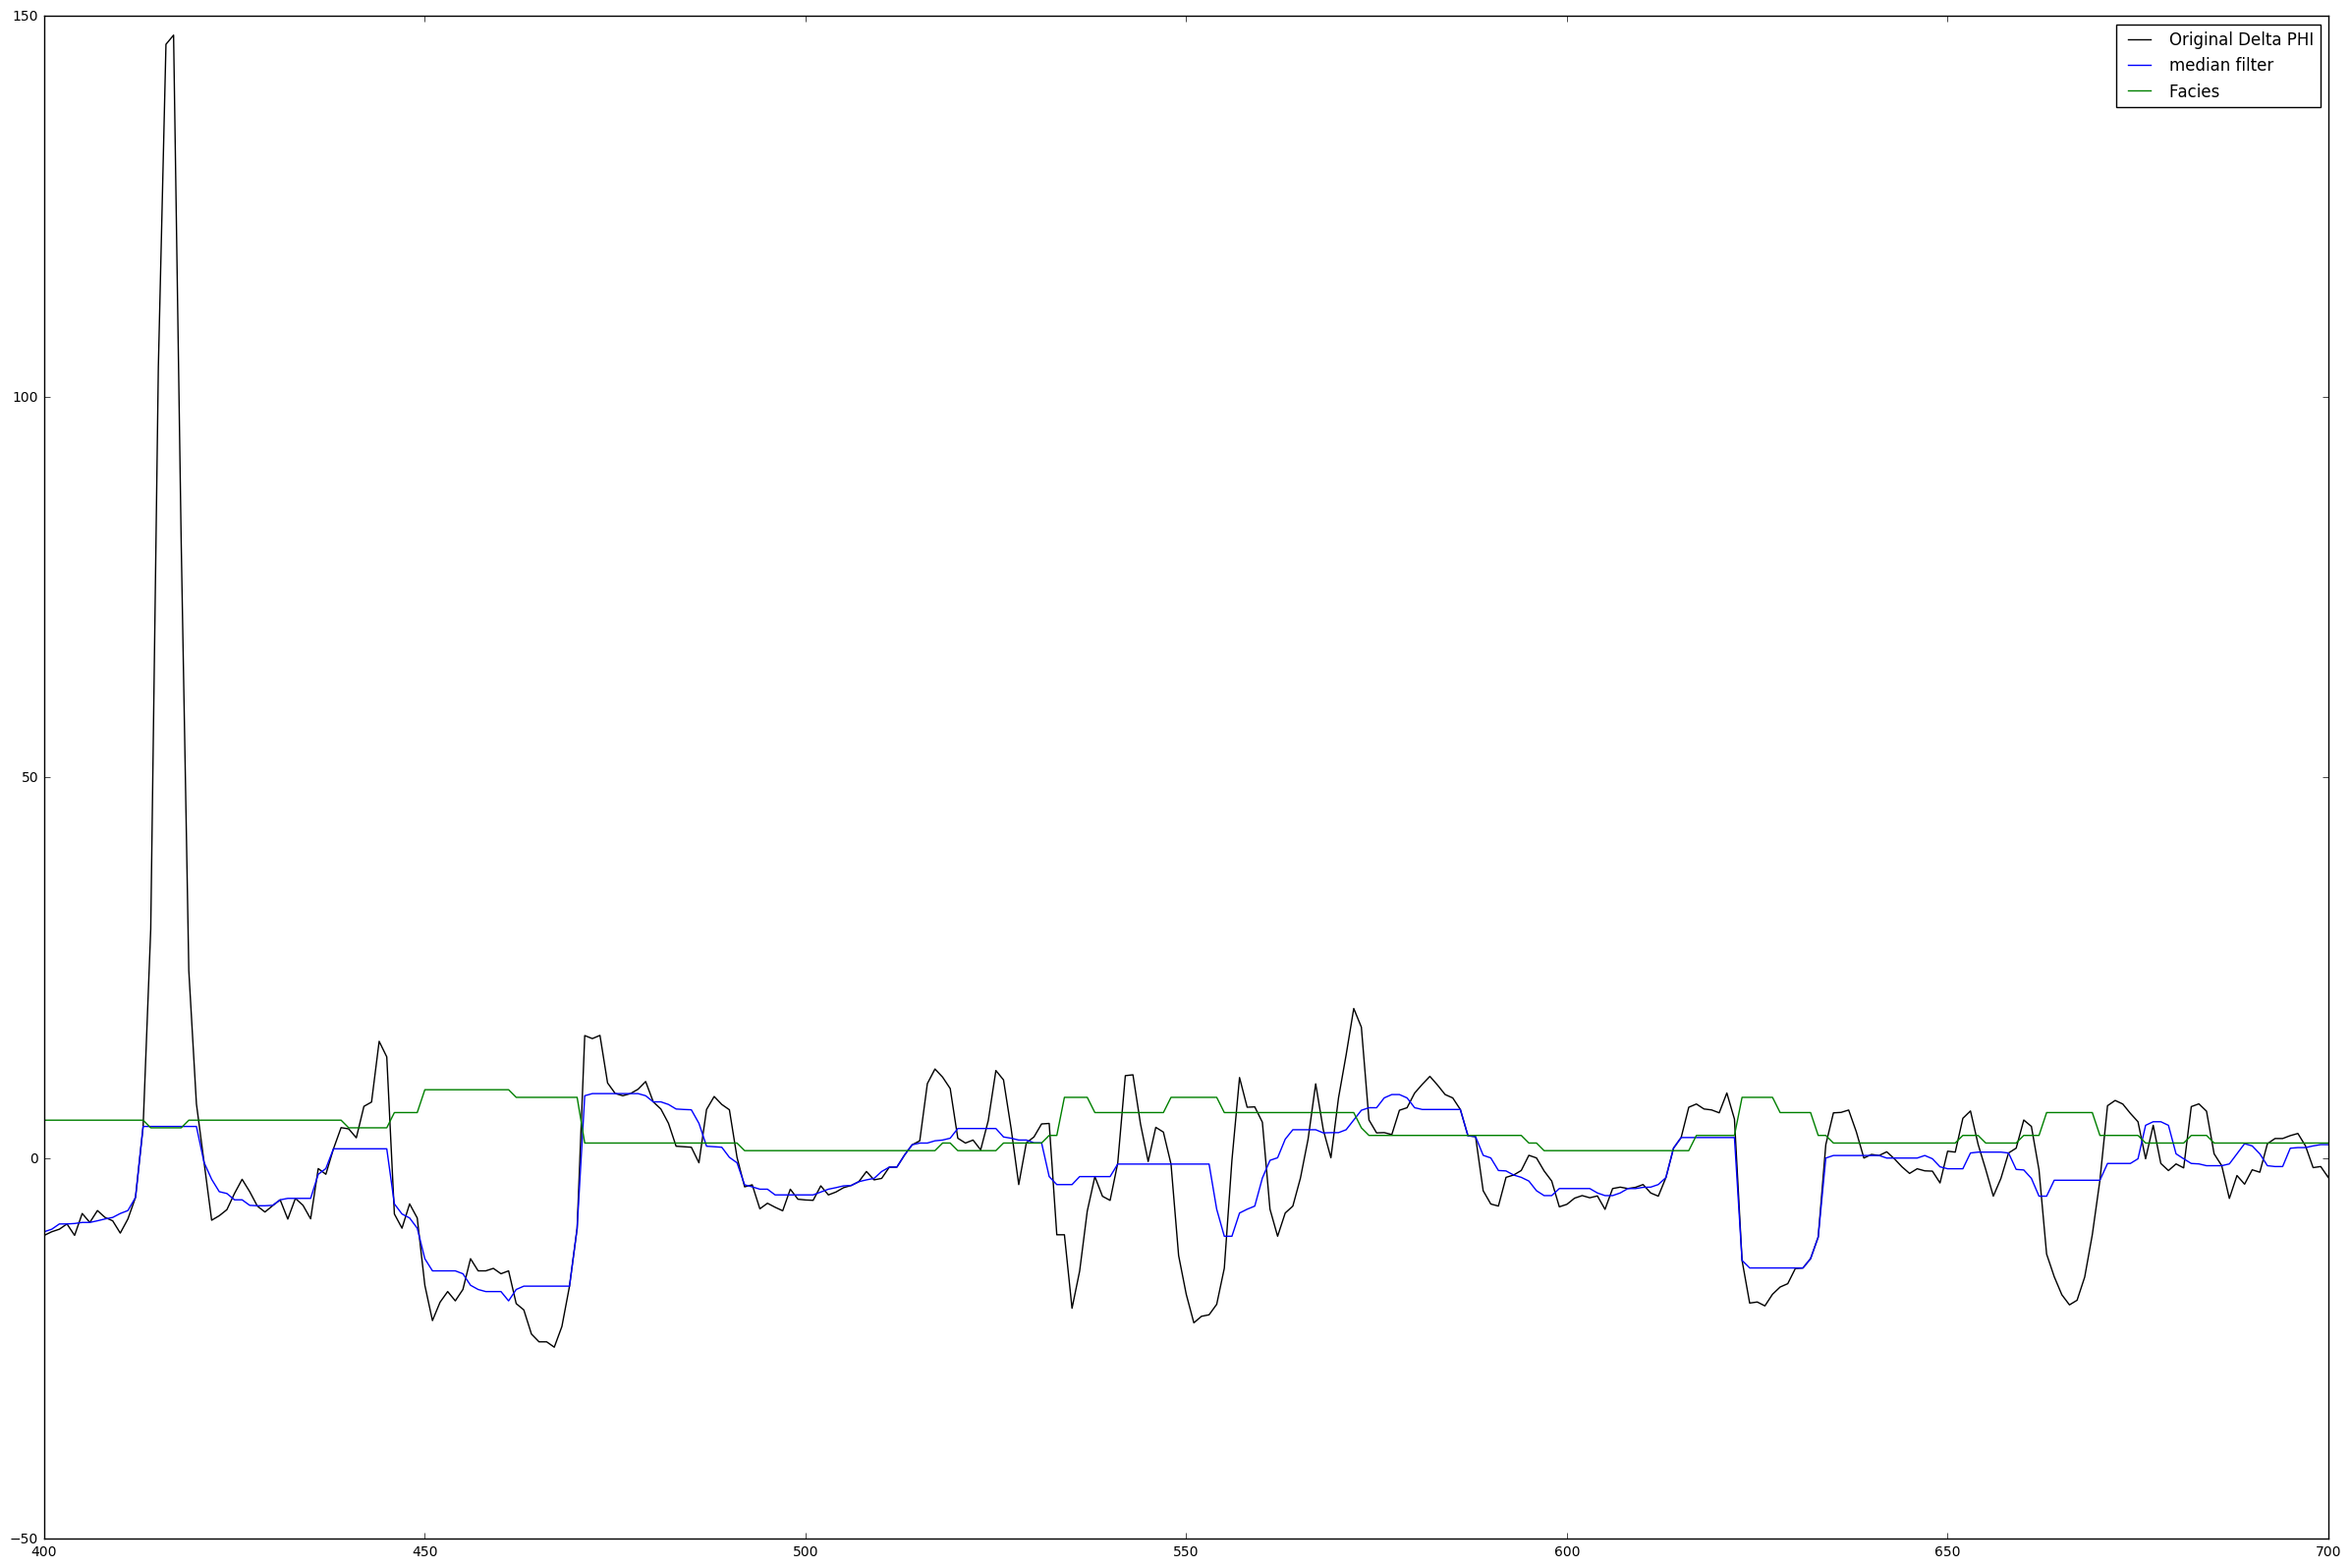

In [1374]:
x_min1=np.roll(xx1, 1)
x_min2=np.roll(xx1, 2)
x_min3=np.roll(xx1, 3)
scale=0.5
#b, a = signal.butter(2, 0.125, analog=False)
b, a = signal.butter(2, 0.09, btype='low', analog=False)
b, a = signal.butter(2, 0.2, btype='high', analog=False)

xx1=xx1-np.mean(xx1) 
xx_fil = signal.filtfilt(b, a, xx1)
xx_mf= signal.medfilt(xx1,15)

xx_grad=np.gradient(xx1)

fig, ax = plt.subplots(figsize=(30, 20))

plt.plot(scale*xx1, color='black', label='Original Delta PHI')

#plt.plot(scale*xx_grad, color='blue', label='derivative')
#plt.plot(scale*xx_fil, color='red', label='low pass filter')
#plt.plot(scale*xx_fil, color='red', label='high pass filter')
plt.plot(scale*xx_mf, color='blue', label='median filter')
#plt.plot(x_min1, color='yellow', label='1 sample shift')
#xlim([500 800])
plt.plot(xx0, color='green', label='Facies')
ax.set_xlim(400,700)
#plt.plot(sig_lf, color='#cc0000', label='lfilter')
plt.legend(loc="best")
plt.show()

In [1608]:

def magic(df):
    df1=df.copy()
    b, a = signal.butter(2, 0.2, btype='high', analog=False)
    feats00=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    feats01=['GR','DeltaPHI','PHIND']
    for ii in feats0:
        df1[ii]=df[ii]
        name1=ii + '_1'
        name2=ii + '_2'
        name3=ii + '_3'
        name4=ii + '_4'
        xx1 = list(df[ii])
        xx_mf= signal.medfilt(xx1,9)
        x_min3=np.roll(xx_mf, 3)    
        xx1a=xx1-np.mean(xx1)
        xx_fil = signal.filtfilt(b, a, xx1)
        xx_grad=np.gradient(xx1a) 
        if ii in feats01: 
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            df1[name4]=xx_mf     
    return df1

        
#del training_data1
df=training_data0.copy()
training_data1=magic(df)

        
        

14
11


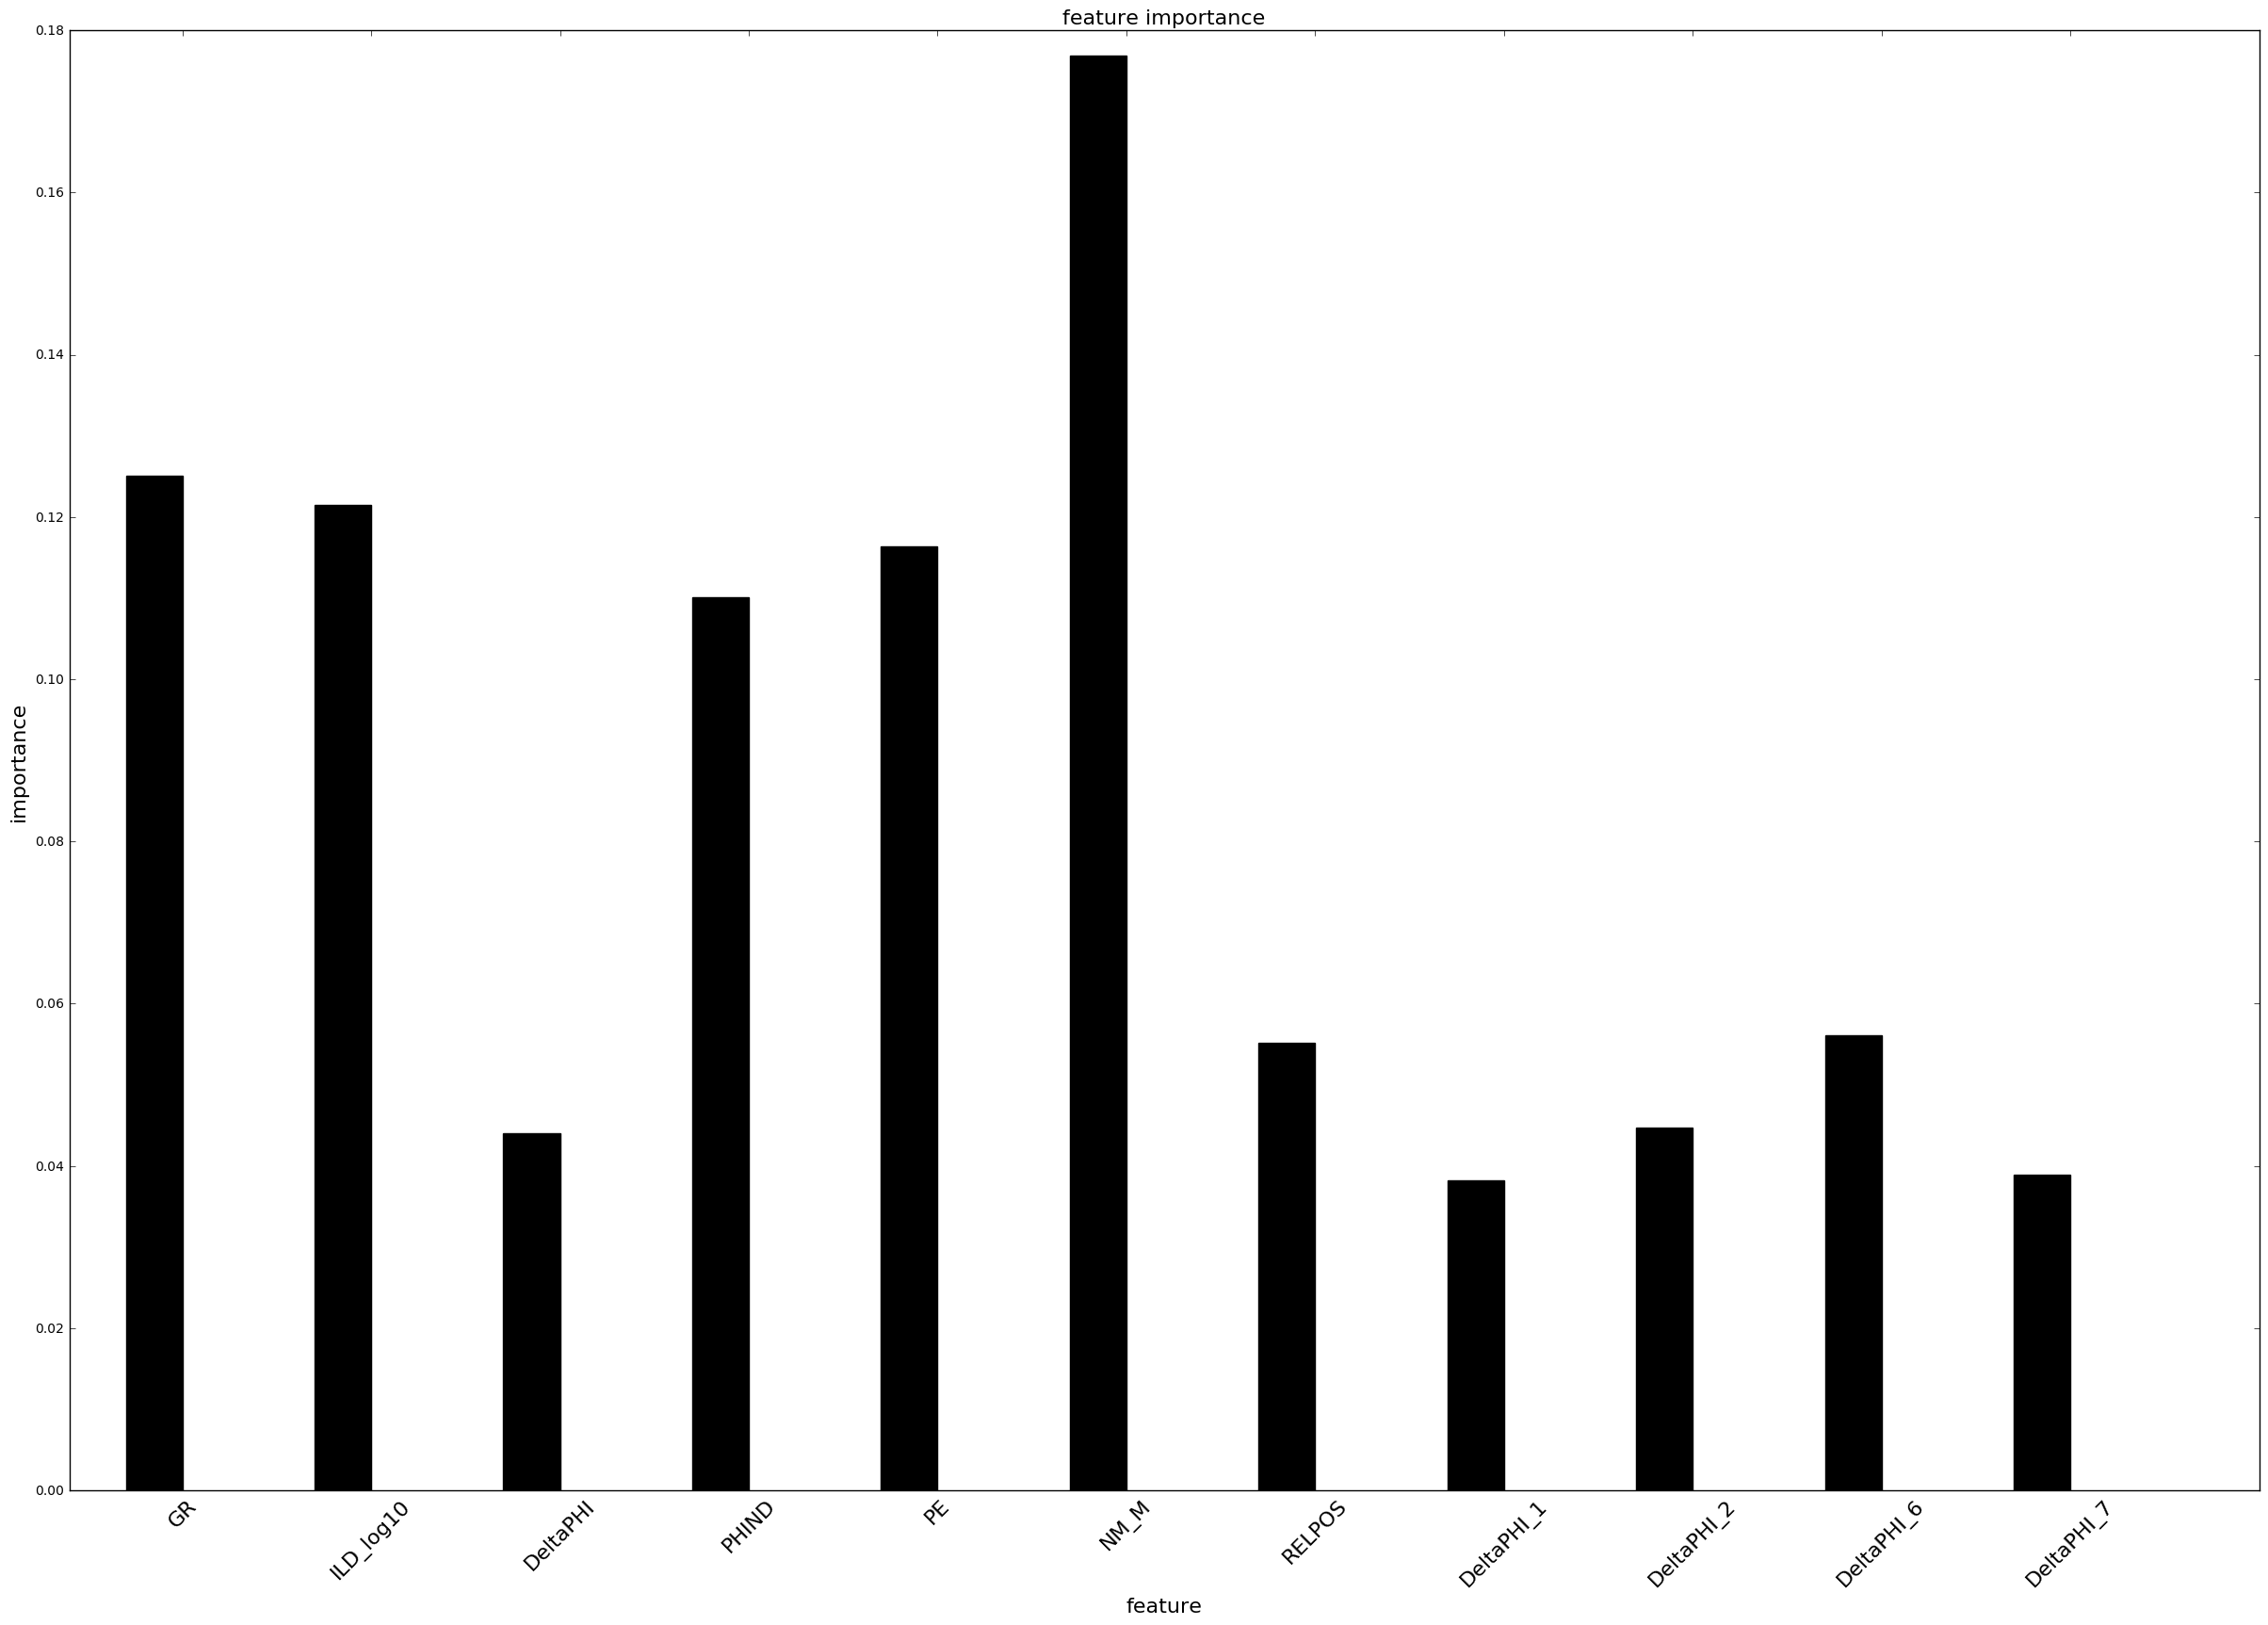

In [1412]:
x=rf.feature_importances_
kolummen = feature_vectors.columns.tolist()
mask=x>0.025
mask=x>0.035
#mask=x>0.025
x1=x[mask]

#kols=kolummen[mask]
kols=[]
kols_out=[]
count=0
for name in kolummen:
    if mask[count]==True:
        kols.append(name)
    else:
        kols_out.append(name)
    count+=1        
fig, ax = plt.subplots(figsize=(30, 20))


## the data
N = len(kols)
#N = len(kolummen)-18

#X=gradboost.feature_importances_
#X=rf.feature_importances_
X=x1

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.30                      # the width of the bars
fsize=16
## the bars
rects1 = ax.bar(ind, X, width,
                color='black')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
#ax.set_ylim(0,45)
ax.set_xlabel('feature', fontsize=fsize)
ax.set_ylabel('importance', fontsize=fsize)
ax.set_title('feature importance', fontsize=fsize)
#xTickMarks = ['Group'+str(i) for i in range(1,6)]
xTickMarks = kols
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks, fontsize=fsize)
plt.setp(xtickNames, rotation=45, fontsize=fsize)

## add a legend
#ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )
print count
print N
plt.show()

In [1413]:
training_data1a = training_data1.drop(kols_out, axis=1)
training_data1a.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,DeltaPHI_1,DeltaPHI_2,DeltaPHI_6,DeltaPHI_7
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS,2.241,2.241,9.9,2.241
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS,2.241,9.900,13.5,2.241
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS,2.241,13.500,13.9,9.900
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS,9.900,13.900,14.0,13.500
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS,13.500,14.000,14.2,13.900


In [1614]:

def run_test(remove_well, df_train):
    #df_test=training_data0
    df_test=training_data1
    #---------------------------------
    #df_train=training_data1a
    #df_train=training_data2
    #df_test=df_test.drop(kols_out, axis=1)
    #---------------------------------
    #df_train=training_data0
    #df_train=training_data1

    #df_train=df_train.drop(kols_out, axis=1)

    #training_data1a = training_data1.drop(kols_out, axis=1)


    blind = df_test[df_test['Well Name'] == remove_well]      
    training_data = df_train[df_train['Well Name'] != remove_well]  

    correct_facies_labels_train = training_data['Facies'].values
    feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    #scaled_features_train = scaler.transform(feature_vectors)
    scaled_features_train = feature_vectors
    
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    #rf = RandomForestClassifier()
    rf.fit(scaled_features_train, correct_facies_labels_train)


    # get the blind well
    correct_facies_labels = blind['Facies'].values
    feature_vectors = blind.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    #scaled_features = scaler.transform(feature_vectors)
    scaled_features =feature_vectors

    predicted_random_forest = rf.predict(scaled_features)
    #print "All training data different from test well"
    #print "prediction from random forest:"
    #print metrics.accuracy_score(correct_facies_labels, predicted_random_forest)

    #printnt "f1 score:"
    #print metrics.f1_score(correct_facies_labels, predicted_random_forest,average = None)
    #print "average"
    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return out_f1
#print 

# 5-Fold Cross validation
#print "3-Fold Cross validation"
#cv_scores = cross_val_score(rf, scaled_features, correct_facies_labels, cv=4, scoring='f1_macro')
#avg_cv_score = np.mean(cv_scores)

#print cv_scores
#avg_cv_score
    
    

In [1615]:
#df_train=training_data1a
df_train=training_data1
wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']
av_all=[]
for remove_well in wells:
    all=[]
    print("well : %s, f1 for different runs:" % (remove_well))
    for ii in range(3):
        out_f1=run_test(remove_well,df_train)                
        all.append(out_f1)
    av1=np.mean(all) 
    av_all.append(av1)
    print("average f1 is %f, 2*std is %f" % (av1, 2*np.std(all)) )

print("overall average f1 is %f" % (np.mean(av_all)))


well : CHURCHMAN BIBLE, f1 for different runs:
average f1 is 0.577558, 2*std is 0.023684
well : SHANKLE, f1 for different runs:
average f1 is 0.510765, 2*std is 0.009153
well : NOLAN, f1 for different runs:
average f1 is 0.500402, 2*std is 0.018596
well : NEWBY, f1 for different runs:
average f1 is 0.506120, 2*std is 0.008876
well : Recruit F9, f1 for different runs:
average f1 is 0.803922, 2*std is 0.013865
well : CROSS H CATTLE, f1 for different runs:
average f1 is 0.379907, 2*std is 0.013173
well : LUKE G U, f1 for different runs:
average f1 is 0.613160, 2*std is 0.012440
well : SHRIMPLIN, f1 for different runs:
average f1 is 0.592357, 2*std is 0.015113
overall average f1 is 0.560524


In [1572]:
#rf = RandomForestClassifier(max_depth = 1, max_features= 'sqrt', n_estimators=50, oob_score = True) 
rfc = RandomForestClassifier(max_depth = 9, max_features= 'sqrt', n_estimators=250) 
#rf = RandomForestClassifier()
#rf.fit(scaled_features_train, correct_facies_labels_train)
param_grid = { 
    'max_depth'   : [5,6,7,8,9],
    'n_estimators': [150, 250, 350, 600]
}    
#    'max_features': ['auto', 'sqrt', 'log2']
#}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X, y)
CV_rfc.fit(scaled_features_train, correct_facies_labels_train)
print CV_rfc.best_params_

{'n_estimators': 350, 'max_depth': 5}


Train for the test data
---------------------------------------------------

In [1633]:
filename = 'training_data.csv'
training_data = pd.read_csv(filename)

In [1642]:
filename = 'validation_data_nofacies.csv'
test_data = pd.read_csv(filename)

In [1643]:
test_data.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [1635]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [1636]:
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D','PS', 'BS']    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [1657]:
#preprocessing
test_data1=magic(test_data)
training_data1=magic(training_data)

In [1665]:

def predict_final(test_well, training_data,test_data):
    blind = test_data[test_data['Well Name'] == test_well]      
    correct_facies_labels_train = training_data['Facies'].values
    feature_vectors_train = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(feature_vectors_train, correct_facies_labels_train)

    # the blind well
    feature_vectors_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)
    predicted_random_forest = rf.predict(feature_vectors_blind)
    #out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return predicted_random_forest

        

In [1666]:
test_well='STUART'
predicted_stu=predict_final(test_well, training_data1, test_data1)
test_well='CRAWFORD'
predicted_craw=predict_final(test_well, training_data1, test_data1)


In [1669]:
predicted_stu

array([2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 8, 8, 8,
       8, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6, 8, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 5, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 2, 2, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8,

In [1670]:
predicted_craw

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 5, 5, 7, 7, 7, 7, 7, 4, 4, 4, 4,
       4, 7, 4, 4, 4, 4, 4, 6, 4, 4, 4, 8, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 6,
       8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       4, 4, 4, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 6,
       6, 6, 6, 6, 6, 6, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8,
       6, 8, 8, 8, 6, 6, 6, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7,